# Blind Evaluation
We have evaluated our model in the rare decay mode. The normalisation mode is $\Lambda_B\rightarrow pK [J/\pi\rightarrow\mu\mu]$ and we will now use this mode to evaluate our perfromance as if it ere the rare mode. We can then compare our estimated performance to the unblind mode. 

In [39]:
import os
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
import zfit 
from zfit import z
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [33]:
train = pd.read_csv('../data_files/8.0.5/train.csv', index_col=[0])
val = pd.read_csv('../data_files/8.0.5/val.csv', index_col=[0])
test = pd.read_csv('../data_files/8.0.5/test.csv', index_col=[0])

## Applying $q^2$ Veto
Now we have loaded the separate sets of data, since we have reblined the 5.2-5.8 GeV region we know that all the events marked as signal will indeed be simulated. To be more specific about our signal we can work in a particular interval of the dilepton invariant mass, $q^2$. In this case we want that to be similar to the mass of the $J/\psi(1S)$.

In [34]:
# Count how many of each event are in the training & val sample currently
nevents = {'train': {'bg': train.category.value_counts()[0], 'sg': train.category.value_counts()[1]},
    'val': {'bg': val.category.value_counts()[0], 'sg': val.category.value_counts()[1]}}

print(nevents)
# We do this so that we can maintain a roughly equal ratio of sig/bg after the q-squared cuts

{'train': {'bg': 15591, 'sg': 15572}, 'val': {'bg': 5155, 'sg': 5233}}


In [35]:
jpsi_qsqr_veto = (3000, 3178)
# Use a tuple here as it is immutable

train = train[np.logical_or(np.logical_and(train['category']==1, train['QSQR'].between(*jpsi_qsqr_veto)), train['category']==0)]
val = val[np.logical_or(np.logical_and(val['category']==1, val['QSQR'].between(*jpsi_qsqr_veto)), val['category']==0)]
# Apply the q-squared veto

nevents_after = {'train': {'bg': train.category.value_counts()[0], 'sg': train.category.value_counts()[1]},
    'val': {'bg': val.category.value_counts()[0], 'sg': val.category.value_counts()[1]}}

print(nevents_after)

{'train': {'bg': 15591, 'sg': 15290}, 'val': {'bg': 5155, 'sg': 5143}}


Since this veto only remove ~300 events in the training sample (1% of the entire sample) and similar in the validation sample we do not ned to equalise our events again as the number are pretty similar we shouldn't be introducing any bias.

## Retrain Neural Network
We have now applied our preselection (this was done by Dan in the tuples) then our $q^2$ veto on the signal events. We have also blinded the data in the same mass region as in our rare mode. We can now retrain the neural network a little on the same variables and assess the performance!

In [37]:
X_train = train.drop(['IsSimulated', 'category', 'Lb_M', 'QSQR'], axis=1)
y_train = train.category

X_val = val.drop(['IsSimulated', 'category', 'Lb_M', 'QSQR'], axis=1)
y_val = val.category

In [43]:
model = tf.keras.models.load_model('../neural_network/models/v9.0.5')
# Load our original model

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
# Recompile

In [44]:
custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/100
61/61 [==============================] - ETA: 1:27 - loss: 0.4233 - binary_accuracy: 0.8652 - auc: 0.928 - ETA: 0s - loss: 0.3039 - binary_accuracy: 0.8902 - auc: 0.9513  - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8971 - auc: 0.958 - ETA: 0s - loss: 0.2728 - binary_accuracy: 0.8988 - auc: 0.960 - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.9007 - auc: 0.963 - ETA: 0s - loss: 0.2601 - binary_accuracy: 0.9027 - auc: 0.964 - ETA: 0s - loss: 0.2546 - binary_accuracy: 0.9053 - auc: 0.966 - ETA: 0s - loss: 0.2512 - binary_accuracy: 0.9065 - auc: 0.967 - 2s 15ms/step - loss: 0.2485 - binary_accuracy: 0.9072 - auc: 0.9680 - val_loss: 0.2076 - val_binary_accuracy: 0.9243 - val_auc: 0.9807
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.2012 - binary_accuracy: 0.9297 - auc: 0.980 - ETA: 0s - loss: 0.2164 - binary_accuracy: 0.9184 - auc: 0.976 - ETA: 0s - loss: 0.2227 - binary_accuracy: 0.9153 - auc: 0.974 - ETA: 0s - loss: 0.2196 - binary_accuracy: 0.9173 - 

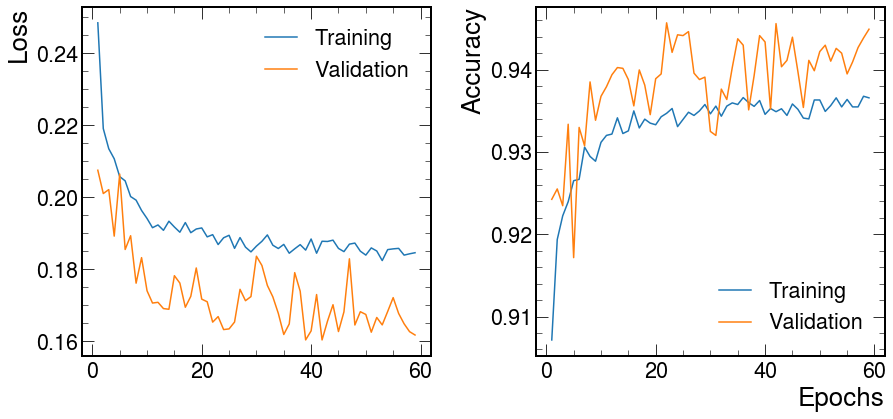

In [62]:
# Plot the loss and accuracy during re-training
epochs = np.arange(1, len(history.history['loss'])+1)
fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharex=True)

ax[0].plot(epochs, history.history['loss'], label='Training')
ax[0].plot(epochs, history.history['val_loss'], label='Validation')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['binary_accuracy'], label='Training')
ax[1].plot(epochs, history.history['val_binary_accuracy'], label='Validation')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.xlabel('Epochs')
plt.show()

In [63]:
# Resave our newly trained model
tf.keras.models.save_model(model, 'normalisation_model_9.0.5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-04-01 12:45:35.034479: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [76]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

X_test = test.drop(['IsSimulated', 'Lb_M', 'category', 'QSQR'], axis=1)
y_test = test.category.to_numpy()

print(f"Accuracy: {accuracy_score(y_test, np.where(model.predict(X_test)>0.8,1,0))*100:.2f}%")

Accuracy: 92.50%


## Retune Punzi FoM
Now we can evaluate how our model has performed but before all this we need to retune the Punzi cut point.

In [77]:
# TODO: Implement this... assume it is ~0.8 for now

## Residual Mass Distribution

In [78]:
preds = model.predict(X_test).flatten()
test['pred_class'] = np.where(preds > 0.8, 1, 0)

In [88]:
purity = np.count_nonzero(np.logical_and(test['pred_class']==1,test['category']==1))/np.count_nonzero(test['pred_class']==1)
eff = np.count_nonzero(np.logical_and(test['pred_class']==1,test['category']==1))/np.count_nonzero(test['category']==1)

print(f"Purity: {(purity)*100:.2f}%\nEfficiency: {(eff*100):.2f}%")

Purity: 96.90%
Efficiency: 87.73%


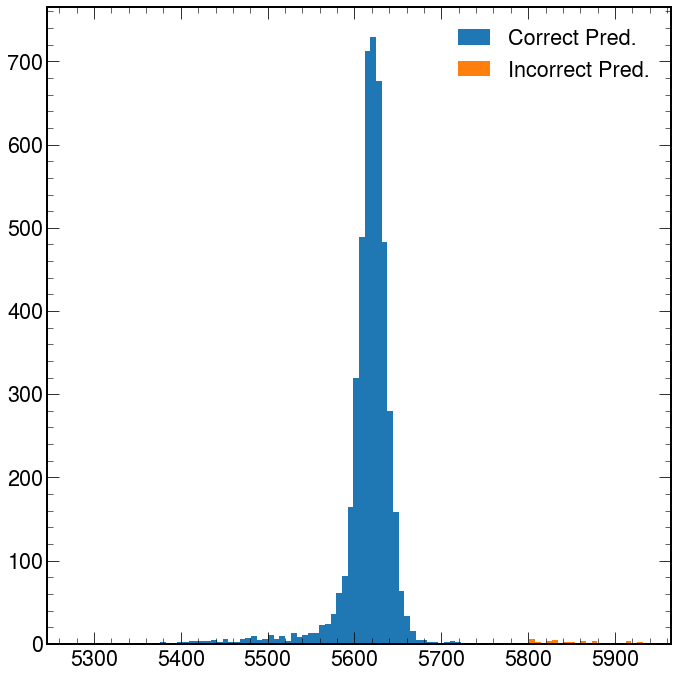

In [85]:
fig, ax = plt.subplots(1, 1)
h, bins = np.histogram(test['Lb_M'][np.logical_and(test['pred_class']==1,test['category']==1)], bins=100)
h2, _ = np.histogram(test['Lb_M'][np.logical_and(test['pred_class']==1,test['category']==0)], bins=bins)
hep.histplot([h, h2], bins=bins, ax=ax, label=['Correct Pred.', 'Incorrect Pred.'], stack=True, histtype='fill')
plt.legend()
plt.tight_layout()
plt.show()